# Final Submission

Problem Regarding the Compute Power:- https://www.youtube.com/watch?v=MHTsS0XEx8E&ab_channel=HACKANONS

In [3]:
# all imports needed for this project
!pip install plotly
!pip install sklearn
!pip install numpy
!pip install scipy
!pip install scikit-plot
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import plotly.io as pio
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scikitplot as skplt
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder
import sklearn.discriminant_analysis
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/



#Data Pre-Processing




First, we load our raw data we found through the BTS website into a pandas dataset. The file size is 2GB so it takes a while to load.

In [ ]:
data = pd.read_csv("/content/drive/Shared drives/CSCE320/Final Submission/FlightDelays.csv", low_memory=False)
data.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,CARRIER,FL_NUM,Route,ORIGIN,DEST,DEST_CITY,DEST_STATE,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CANCELED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,PASSENGERS,EMPFULL,EMPPART,EMPTOTAL,EMPFTE,NET_INCOME,OP_REVENUES
0,2018,1,1,1,1,2018-01-01,9E,3331,42,ABY,ATL,"Atlanta, GA",GA,700,656.0,-4.0,0.0,0.0,-1.0,0700-0759,11.0,707.0,745.0,6.0,803,751.0,-12.0,0.0,0.0,-1.0,0800-0859,0,NaN,0,63.0,55.0,38.0,145,NaN,NaN,NaN,NaN,NaN,2677.0,4191.0,109.0,4300.0,4246.0,-126.37,674.25
1,2018,1,1,1,1,2018-01-01,9E,3940,42,ABY,ATL,"Atlanta, GA",GA,1511,1510.0,-1.0,0.0,0.0,-1.0,1500-1559,11.0,1521.0,1558.0,6.0,1616,1604.0,-12.0,0.0,0.0,-1.0,1600-1659,0,NaN,0,65.0,54.0,37.0,145,NaN,NaN,NaN,NaN,NaN,2677.0,4191.0,109.0,4300.0,4246.0,-126.37,674.25
2,2018,1,1,2,2,2018-01-02,9E,3409,42,ABY,ATL,"Atlanta, GA",GA,625,620.0,-5.0,0.0,0.0,-1.0,0600-0659,13.0,633.0,711.0,9.0,726,720.0,-6.0,0.0,0.0,-1.0,0700-0759,0,NaN,0,61.0,60.0,38.0,145,NaN,NaN,NaN,NaN,NaN,2677.0,4191.0,109.0,4300.0,4246.0,-126.37,674.25
3,2018,1,1,2,2,2018-01-02,9E,3940,42,ABY,ATL,"Atlanta, GA",GA,1511,1507.0,-4.0,0.0,0.0,-1.0,1500-1559,11.0,1518.0,1552.0,6.0,1616,1558.0,-18.0,0.0,0.0,-2.0,1600-1659,0,NaN,0,65.0,51.0,34.0,145,NaN,NaN,NaN,NaN,NaN,2677.0,4191.0,109.0,4300.0,4246.0,-126.37,674.25
4,2018,1,1,3,3,2018-01-03,9E,3353,42,ABY,ATL,"Atlanta, GA",GA,630,631.0,1.0,1.0,0.0,0.0,0600-0659,11.0,642.0,715.0,11.0,729,726.0,-3.0,0.0,0.0,-1.0,0700-0759,0,NaN,0,59.0,55.0,33.0,145,NaN,NaN,NaN,NaN,NaN,2677.0,4191.0,109.0,4300.0,4246.0,-126.37,674.25


We then move on to cleaning our dataset by removing columns and rows that we did not need. We decided which columns based on their potential impact on an airport's efficiency. Variables such as delays and cancellations were deemed useful, while variables such as flight number, destination city/state names were deemed not useful.

We also decided to only use data from the year 2019 as that gives the most accurate representation of the airport's efficiency and reduces computational time.

In the end, the following were removed:
*   Rows which contained info before the year 2019.
*   Following columns: 
        'FL_NUM', 'DEST_CITY', 'DEST_STATE', 'CRS_DEP_TIME', 'DEP_TIME_BLK', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN','CRS_ARR_TIME', 'ARR_TIME', 'ARR_DEL15', 'OP_REVENUES', 'NET_INCOME', 'EMPFTE', 'EMPTOTAL', 'EMPPART', 'EMPFULL', 'LATE_AIRCRAFT_DELAY', 'SECURITY_DELAY', 'NAS_DELAY', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'CARRIER', 'Route', 'CANCELLATION_CODE', 'DIVERTED'

In [ ]:
# remove all rows from the 2018 year
clean_data = data[data.YEAR != 2018]
# remove all unwanted columns that will not affect efficiency
clean_data = clean_data.drop(['FL_NUM', 'DEST_CITY', 'DEST_STATE', 'CRS_DEP_TIME', 'DEP_TIME_BLK', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 
           'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DEL15', 'OP_REVENUES', 'NET_INCOME', 'EMPFTE', 'EMPTOTAL', 'EMPPART', 'EMPFULL', 
           'LATE_AIRCRAFT_DELAY', 'SECURITY_DELAY', 'NAS_DELAY', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 
           'DAY_OF_WEEK', 'FL_DATE', 'CARRIER', 'Route', 'CANCELLATION_CODE', 'DIVERTED'], axis=1)
clean_data

,YEAR,ORIGIN,DEST,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,ARR_DELAY,ARR_DELAY_NEW,ARR_DELAY_GROUP,ARR_TIME_BLK,CANCELED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,PASSENGERS
7265956,2019,ABE,ATL,557.0,-3.0,0.0,0.0,-1.0,-9.0,0.0,-1.0,0800-0859,0,148.0,142.0,113.0,692,NaN,NaN,2545.0
7265957,2019,ABE,ATL,554.0,-6.0,0.0,0.0,-1.0,-28.0,0.0,-2.0,0800-0859,0,151.0,129.0,108.0,692,NaN,NaN,2545.0
7265958,2019,ABE,ATL,1747.0,-2.0,0.0,0.0,-1.0,24.0,24.0,1.0,2000-2059,0,145.0,171.0,130.0,692,0.0,0.0,2545.0
7265959,2019,ABE,ATL,558.0,-2.0,0.0,0.0,-1.0,-7.0,0.0,-1.0,0800-0859,0,151.0,146.0,114.0,692,NaN,NaN,2545.0
7265960,2019,ABE,ATL,1752.0,3.0,3.0,0.0,0.0,-17.0,0.0,-2.0,2000-2059,0,145.0,125.0,105.0,692,NaN,NaN,2545.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10915490,2019,XNA,LGA,1619.0,-2.0,0.0,0.0,-1.0,-7.0,0.0,-1.0,2000-2059,0,188.0,183.0,155.0,1147,NaN,NaN,3026.0
10915491,2019,XNA,LGA,653.0,-9.0,0.0,0.0,-1.0,-16.0,0.0,-2.0,1100-1159,0,187.0,180.0,157.0,1147,NaN,NaN,3026.0
10915492,2019,XNA,LGA,1615.0,-6.0,0.0,0.0,-1.0,NaN,NaN,NaN,2000-2059,0,188.0,NaN,NaN,1147,NaN,NaN,3026.0
10915493,2019,XNA,LGA,820.0,-4.0,0.0,0.0,-1.0,4.0,4.0,0.0,1200-1259,0,186.0,194.0,164.0,1147,NaN,NaN,3026.0


With the rows and columns we didn't need gone, we now proceeded to average all our for each airport. We did this to get a better overall picture of each airport's data and check whether they had significant differences.

We evaluated the values for carrier and weather delay that were "NaN" to be 0 since they were not the cause for any delay for the respective flight.

This process took (and will take) more than 3 hours to finish. To save time, this cell has not been run in THIS COPY as it is redundant due to our next step.

In [ ]:
# creating new dataframe with each airport and it's average stats
average_stats = {'airports': clean_data['ORIGIN'].unique()}
average_stats = pd.DataFrame(average_stats)
average_stats = average_stats.set_index('airports')
average_stats['average_dep_delay'] = 0
average_stats['average_arr_delay'] = 0
average_stats['cancel_rate'] = 0
average_stats['weather_delay_rate'] = 0
average_stats['carrier_delay_rate'] = 0
average_stats['avg_passengers_per_day'] = 0
average_stats['total_flights'] = 0
average_stats['total_departures'] = 0
average_stats['total_arrivals'] = 0
average_stats['dep_delay_rate'] = 0
average_stats['arr_delay_rate'] = 0

for i in clean_data.index:
  port_name = clean_data.loc[i, 'ORIGIN']
  dest_name = clean_data.loc[i, 'DEST']

  if (not pd.isna(clean_data.loc[i, 'DEP_DELAY'])):
    average_stats.loc[port_name, 'average_dep_delay'] += clean_data.loc[i, 'DEP_DELAY']
    if (clean_data.loc[i, 'DEP_DELAY'] > 0):
      average_stats.loc[port_name, 'dep_delay_rate'] += 1
  
  if (not pd.isna(clean_data.loc[i, 'ARR_DELAY'])):
    average_stats.loc[port_name, 'average_arr_delay'] += clean_data.loc[i, 'ARR_DELAY']
    if (clean_data.loc[i, 'ARR_DELAY'] > 0):
      average_stats.loc[dest_name, 'arr_delay_rate'] += 1
  
  if (clean_data.loc[i, 'CANCELED']):
    average_stats.loc[port_name, 'cancel_rate'] += 1
  
  if (not pd.isna(clean_data.loc[i, 'WEATHER_DELAY'])):
    average_stats.loc[port_name, 'weather_delay_rate'] += 1
  
  if (not pd.isna(clean_data.loc[i, 'CARRIER_DELAY'])):
    average_stats.loc[port_name, 'carrier_delay_rate'] += 1
  
  if (not pd.isna(clean_data.loc[i, 'PASSENGERS'])):
    average_stats.loc[port_name, 'avg_passengers_per_day'] += clean_data.loc[i, 'PASSENGERS']

  average_stats.loc[port_name, 'total_departures'] += 1
  average_stats.loc[dest_name, 'total_arrivals'] += 1

average_stats['total_flights'] = average_stats['total_arrivals'] + average_stats['total_departures']
average_stats['dep_delay_rate'] /= average_stats['total_departures']
average_stats['arr_delay_rate'] /= average_stats['total_arrivals']
average_stats['average_dep_delay'] /= average_stats['total_flights']
average_stats['average_arr_delay'] /= average_stats['total_flights']
average_stats['cancel_rate'] /= average_stats['total_departures']
average_stats['weather_delay_rate'] /= average_stats['total_flights']
average_stats['carrier_delay_rate'] /= average_stats['total_flights']
average_stats['avg_passengers_per_day'] /= 365

average_stats.head(20)

In order to not run this lengthy process multiple times, we decided to store the average stats in a file (average_stats.csv) and use it for the upcoming steps.

In [ ]:
average_data = pd.read_csv("/content/drive/Shared drives/CSCE320/Final Submission/average_stats.csv", low_memory=False)
average_data

,airports,average_dep_delay,average_arr_delay,cancel_rate,weather_delay_rate,carrier_delay_rate,avg_passengers_per_day,total_flights,total_departures,total_arrivals,dep_delay_rate,arr_delay_rate
0,ABE,5.209621,3.541453,0.017199,0.099079,0.099079,2.524258e+04,4885,2442,2443,0.291974,0.327876
1,AEX,4.384806,3.545116,0.024814,0.110388,0.110388,1.453365e+04,3225,1612,1613,0.242556,0.324241
2,AGS,6.523003,3.382685,0.014220,0.082811,0.082811,4.806894e+04,4782,2391,2391,0.305312,0.294019
3,ALB,4.937069,1.941111,0.030274,0.090592,0.090592,1.101985e+05,12617,6309,6308,0.285624,0.358117
4,ATL,4.951153,1.683227,0.008001,0.082478,0.082478,1.337311e+07,394907,197230,197677,0.353374,0.278884
...,...,...,...,...,...,...,...,...,...,...,...,...
353,WYS,0.804878,-0.463415,0.000000,0.042683,0.042683,3.226466e+02,164,82,82,0.219512,0.268293
354,AKN,-2.933333,-2.320000,0.040000,0.000000,0.000000,5.219178e+01,75,25,50,0.080000,0.320000
355,DLG,0.440000,0.040000,0.000000,0.100000,0.100000,9.787671e+01,50,25,25,0.400000,0.400000
356,GST,-5.360000,-1.520000,0.000000,0.120000,0.120000,5.027397e+01,50,25,25,0.200000,0.240000


After loading the averaged stats into a pandas dataset, we decided to work on creating a formula which would measure an airport's efficiency for us. We took into consideration several factors and came up with the following formula:

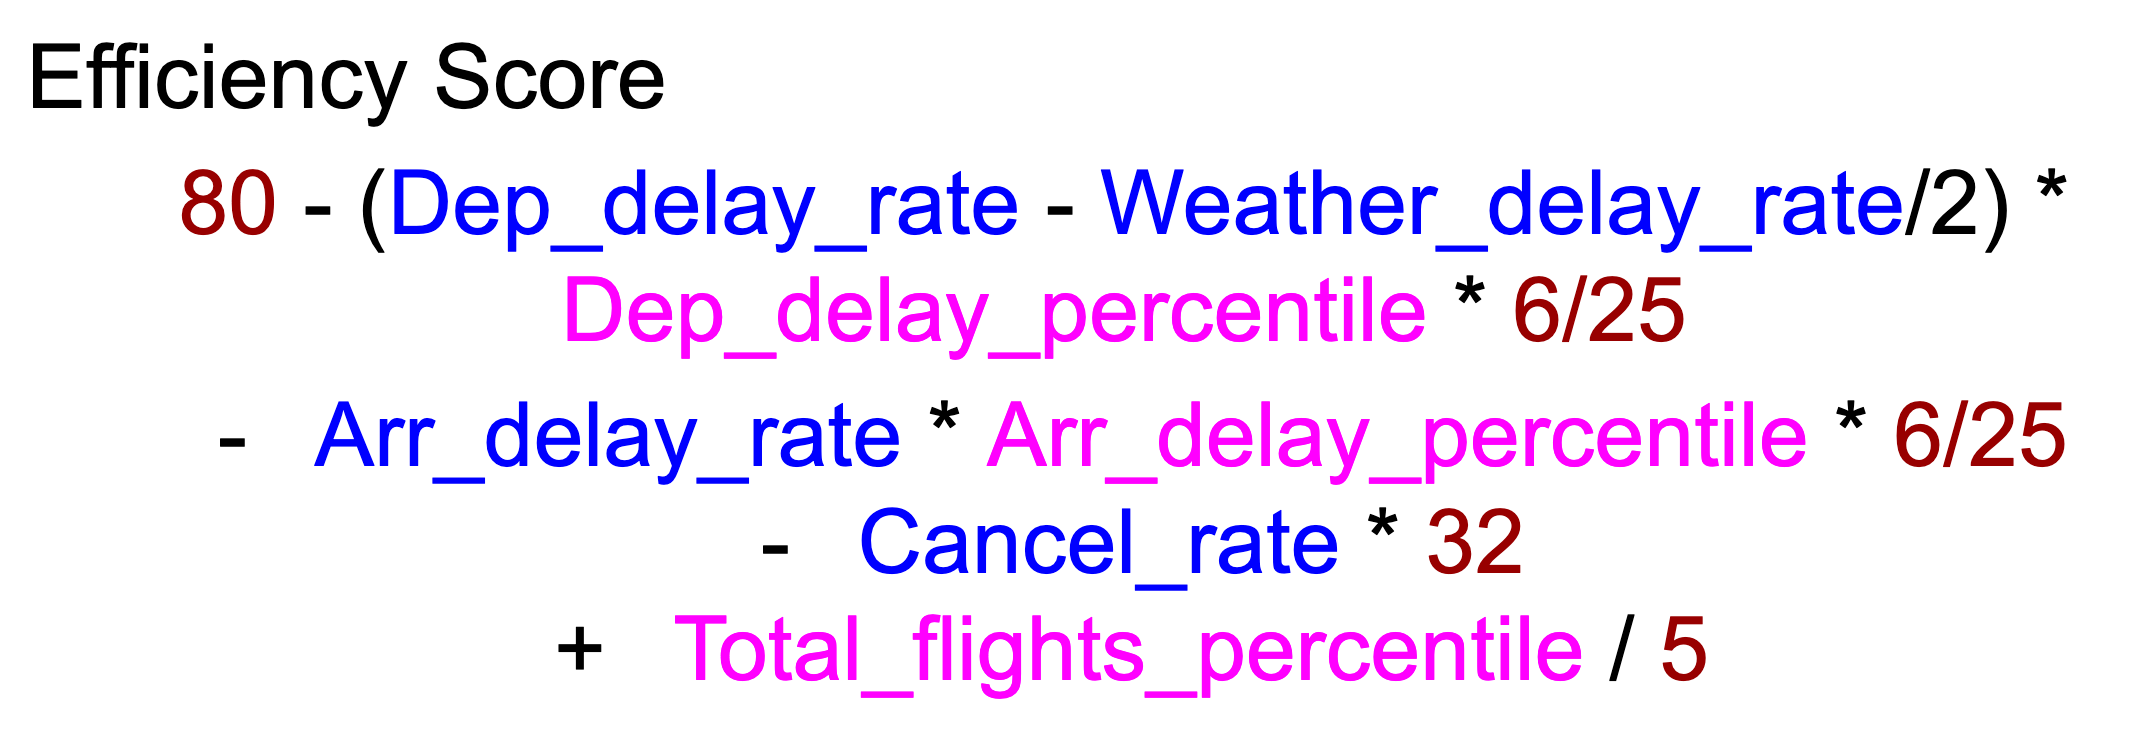

This formula generated a score out of 100 for each airport based on their delay times and rates and cancellation rates, and how it performed in mentioned areas compared to other airports

Upon creating the formula, we generated new columns for all the variables we didn't already have in our dataset. This mainly included the percentiles for each of the fields.

In [ ]:
def round_n(x, base=5):
    return int(base * round(float(x)/base))

sorted_avg_dep_delay = sorted(list(average_data['average_dep_delay']))
sorted_avg_arr_delay = sorted(list(average_data['average_arr_delay']))
sorted_total_flights = sorted(list(average_data['total_flights']))

average_data['average_dep_delay_percentile'] = 0
average_data['average_arr_delay_percentile'] = 0
average_data['total_flights_percentile'] = 0

for i in average_data.index:
  average_data.loc[i, 'average_dep_delay_percentile'] = round_n(sorted_avg_dep_delay.index(average_data.loc[i, 'average_dep_delay'])*100/358)
  average_data.loc[i, 'average_arr_delay_percentile'] = round_n(sorted_avg_arr_delay.index(average_data.loc[i, 'average_arr_delay'])*100/358)
  average_data.loc[i, 'total_flights_percentile'] = round_n(sorted_total_flights.index(average_data.loc[i, 'total_flights'])*100/358)

Finally, we calculated the efficiency score and stored in a new column to be used for later analysis.

In [ ]:
average_data['efficiency_score'] = 80 - (average_data['dep_delay_rate'] - average_data['weather_delay_rate']) * average_data['average_dep_delay_percentile'] * 6/25 - average_data['arr_delay_rate'] * average_data['average_arr_delay_percentile'] * 6/25 - average_data['cancel_rate'] * 32 + average_data['total_flights_percentile']/5

How do we know the formula is good enough though?

To check whether the scores were satisfactory, we plotted the score and score percentile against the other variables to check whether the score behaved approximately the way we wanted it to.

Airports which more traffic should have a higher score than airports with less traffic with similar other stats. The most efficient airport would be one with the highest traffic and lowest delays and rates, while the worst would be a small low-traffic airport with high delays and rates.

I've attached the image with all the plots here, and the code is available in the `Rishabh.ipynb` Notebook.

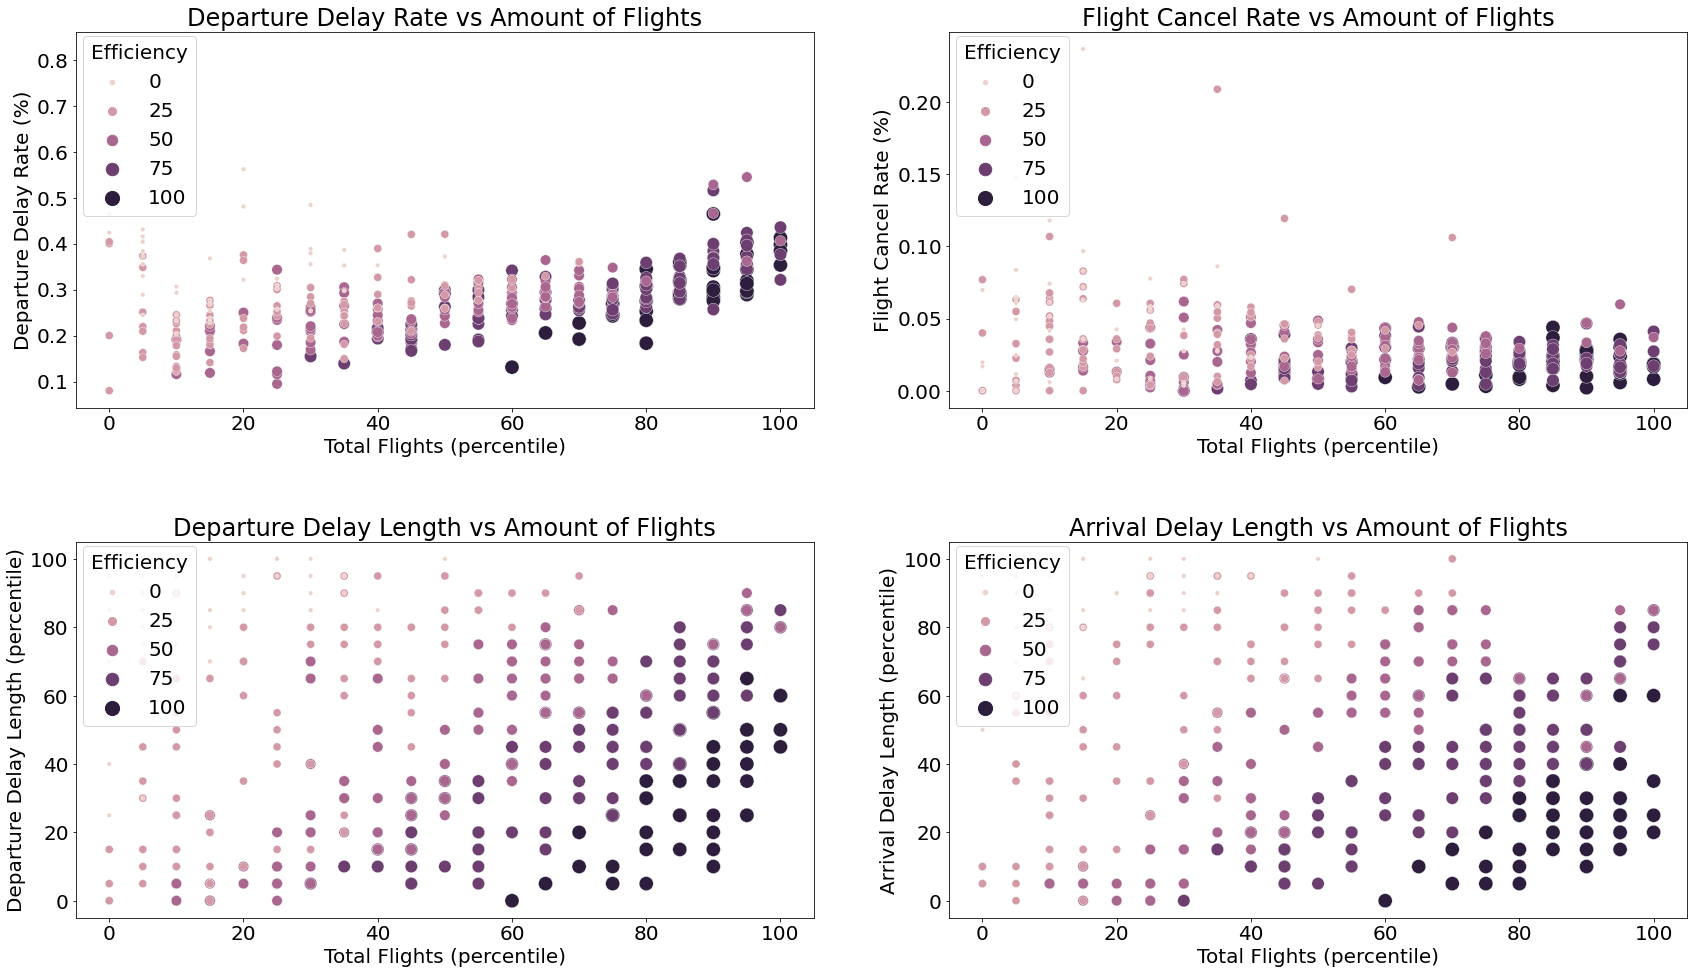

Based on the graphs above, we concluded that the formula scored the airports the way we wanted it to hence validating it for future use.

This concluded the data cleaning and pre-processing state for our project.

### Getting Co-ordinates Ready for final plot

In [ ]:
#Importing Airport Location & Information Files
airport_with_coordinate = pd.read_csv("/content/drive/Shared drives/CSCE320/Final Submission/Airport_with_cord.csv",low_memory=False)
airport_without_coordinate = pd.read_csv("/content/drive/Shared drives/CSCE320/Final Submission/Airport_without_cord.csv",low_memory=False)

#Removing Excess Airports
airport_name_list = airport_without_coordinate["Airport"].tolist()

#Filtering by Country
filtered_df = airport_with_coordinate[airport_with_coordinate['AIRPORT_COUNTRY_NAME'] == 'United States']
sorted_df = filtered_df.sort_values(['AIRPORT', 'DISPLAY_AIRPORT_NAME'], ascending = [True, False])

#Grouping the airport because of extra unwanted entries and further filtering and merging the airport info with coordinates
sorted = sorted_df.groupby('AIRPORT').first().reset_index()
final_airport_df = sorted[sorted['AIRPORT'].isin(airport_name_list)].reset_index()
final_airport_df = final_airport_df.drop(final_airport_df.columns[0], axis=1)
final_airport_df = final_airport_df.drop(['Unnamed: 18'], axis=1)

#Saving the File
final_airport_df.to_csv('Airport.csv',index=False)
!cp Airport.csv "/content/drive/Shared drives/CSCE320/Final Submission/"

### Merging the Airport Data with the Ranked Stats Data

In [ ]:
#Importing Airport Data & Ranked Stats Data
airport_df = pd.read_csv("/content/drive/Shared drives/CSCE320/Final Submission/Airport.csv",low_memory=False)
stats_df = pd.read_csv("/content/drive/Shared drives/CSCE320/Final Submission/ranked_efficiency_stats.csv",low_memory=False)

#Renaming a column in Airport Data
airport_df = airport_df.rename(columns={'AIRPORT': 'airports'})

#Merging Both Data using "airports" as common column
merged_df = pd.merge(airport_df, stats_df, on="airports")

#Saving the File
merged_df.to_csv('airport_loc_stats_comb.csv',index=False)
!cp airport_loc_stats_comb.csv "/content/drive/Shared drives/CSCE320/Final Submission/"

### Correcting Information for some Airport

In [ ]:
airport_df = pd.read_csv("/content/drive/Shared drives/CSCE320/Final Submission/airport_loc_stats_comb.csv",low_memory=False)
airport_df.average_dep_delay=airport_df.average_dep_delay.mask(airport_df.average_dep_delay.lt(0),0)
airport_df['text'] = airport_df['airports'] + ' is Named: ' + airport_df['DISPLAY_AIRPORT_NAME'] + " Located at " + airport_df['DISPLAY_AIRPORT_CITY_NAME_FULL'].astype(str)
airport_df.at[24,'LATITUDE'] = 30.18999924
airport_df.at[24,'LONGITUDE'] = -97.668663992
airport_df.at[24,'DISPLAY_AIRPORT_NAME'] = "Austin-Bergstrom International Airport"
airport_df.head(30)

#Saving the File
airport_df.to_csv('airport_loc_stats_comb.csv',index=False)
!cp airport_loc_stats_comb.csv "/content/drive/Shared drives/CSCE320/Final Submission/"

# Clustering

*1*. Read in data from the preprocessed datafile, 'ranked_efficienct_stats.csv'


In [4]:
data = pd.read_csv("/content/drive/Shared drives/CSCE320/Final Submission/ranked_efficiency_stats.csv",low_memory=False)
data.head()

,airports,average_dep_delay,average_arr_delay,cancel_rate,weather_delay_rate,carrier_delay_rate,avg_passengers_per_day,total_flights,total_departures,total_arrivals,dep_delay_rate,arr_delay_rate,average_dep_delay_percentile,average_arr_delay_percentile,total_flights_percentile,efficiency_score
0,HNL,1.796793,0.107056,0.002060,0.056244,0.056244,2.658769e+06,49516,24757,24759,0.293816,0.345854,10,10,90,96.533858
1,SLC,3.872448,0.358679,0.005647,0.070899,0.070899,1.743219e+06,114275,57021,57254,0.313306,0.330981,25,15,95,96.173323
2,PDX,2.518507,0.390431,0.010076,0.070639,0.070639,1.020587e+06,59004,29576,29428,0.282729,0.344332,15,15,90,95.674458
3,SEA,3.793475,1.115156,0.012283,0.087216,0.087216,3.725178e+06,133679,66840,66839,0.343836,0.366119,25,20,95,95.309855
4,ANC,-0.347386,-2.188664,0.009783,0.050712,0.050712,5.909823e+05,17767,8893,8874,0.183403,0.291413,5,5,80,95.178020


**2**. Run KMeans analysis with elbow method to determine best number of clusters
  - Using inertia as we want to measure the relative similarity to the centroid
  - Then plot the results using matplotlib to inspect the graph and determine the optimal value of k. 
  - This instance of the tests yielded an optimal k value of 5
  - Graph reproduced below


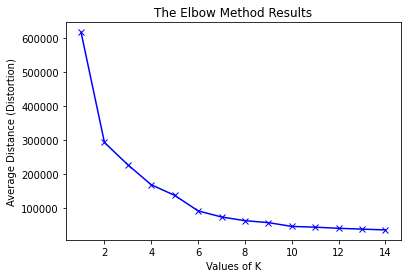

3. Run PCA Analysis to see if we can reduce the dimensionality of our clusters
  - Standardize the dataset
  - Results show that we can drastically reduce the dimensionality of clusters, down to 2
  - Graph reproduced below.


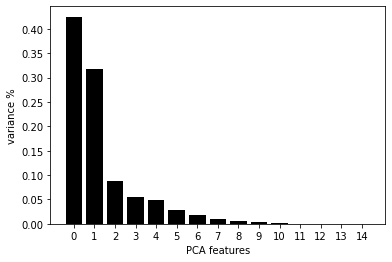

  - We then can plot the PCA components 0 and 1

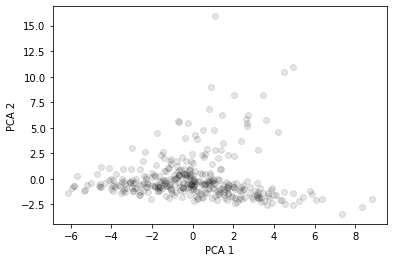

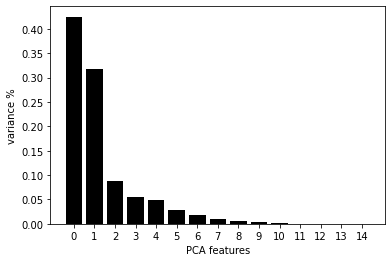

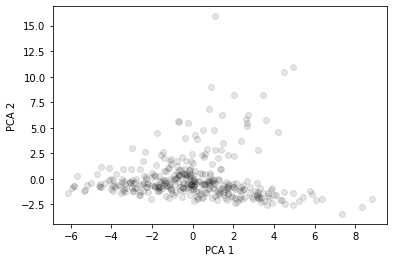

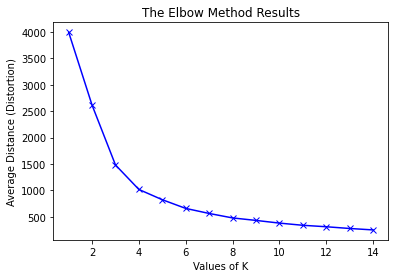

In [5]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist 
import numpy as np
import matplotlib.pyplot as plt  

# 80 - (dep_delay_rate - weather_delay_rate/2)*average_dep_delay_percentile*6/25
#     - arr_delay_rate*average_arr_delay_percentile*6/25
#     - cancel_rate*32
#     + total_flights_percentile/5

data.reset_index()
data.fillna(0, inplace=True)
airports = pd.DataFrame(columns=['airports', 'Cluster Label'])
airports['airports'] = data['airports'].copy()
# data = data.drop(['airports', 'average_dep_delay', 'average_arr_delay', 'carrier_delay_rate', axis=1)
data = data.drop('airports', axis=1)

data_std = StandardScaler().fit_transform(data)

pca = PCA(n_components=15)
principalComponents = pca.fit_transform(data_std)

features_df = pd.DataFrame(principalComponents)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show() 


plt.scatter(features_df[0], features_df[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

results = []
map = {}

# ANALYZE CLUSTERS
def k_analyzer(k):
  df = pd.DataFrame(columns=['k', 'Avg. Distance'])
  model = KMeans(n_clusters=k).fit(features_df.iloc[:,:2])
  model.fit(features_df.iloc[:,:2])
  results.append(model.inertia_)
  


# RUN FUNCTION
K = range(1,15)
for i in K:
  k_analyzer(i)

# PRINT RESULTS
for key,val in map.items(): 
    print(str(key) + ' : ' + str(val)) 

# GRAPH RESULTS
plt.plot(K, results, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Average Distance (Distortion)') 
plt.title('The Elbow Method Results') 
plt.show() 

4. Using optimal value determined above, we run our final model. 
  - n_clusters = 5
  - random_state = 5
  - max_iter = 10000
  - n_init = 100
5. We then score the clusters to see if they have a general ranking. 
  - Most efficient cluster = 0
  - Least efficient cluster = 1

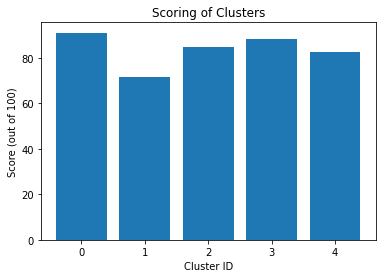



In [6]:
# Clustering
final_model = KMeans(n_clusters=5, random_state=5, max_iter=10000, n_init=100).fit(features_df.iloc[:,:2])
final_model.fit(features_df.iloc[:,:2])
data_w_clusters = data.copy()
data_w_clusters['Cluster'] = pd.Series(final_model.labels_, index=data.index)

dict_keys([0, 1, 2, 3, 4])
dict_values([91.0519640879622, 71.39146435431913, 84.89082537659363, 88.50655936674946, 82.6972664277414])


Text(0, 0.5, 'Score (out of 100)')

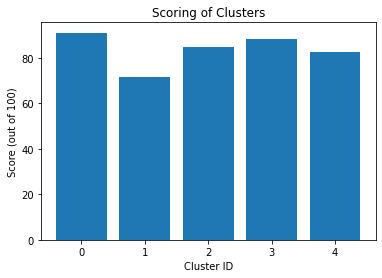

In [7]:
# Scoring
cluster_0 = data_w_clusters[data_w_clusters['Cluster'] == 0]
cluster_1 = data_w_clusters[data_w_clusters['Cluster'] == 1]
cluster_2 = data_w_clusters[data_w_clusters['Cluster'] == 2]
cluster_3 = data_w_clusters[data_w_clusters['Cluster'] == 3]
cluster_4 = data_w_clusters[data_w_clusters['Cluster'] == 4]
matrix = [cluster_0, cluster_1, cluster_2, cluster_3, cluster_4]
scoring = {
    0:0,
    1:0,
    2:0,
    3:0,
    4:0
}


# 80 - (dep_delay_rate - weather_delay_rate/2)*average_dep_delay_percentile*6/25
#     - arr_delay_rate*average_arr_delay_percentile*6/25
#     - cancel_rate*32
#     + total_flights_percentile/5


i = 0
for cluster in matrix:
  for (_,row) in cluster.iterrows():
    scoring[i] = scoring[i] + row[14]
  i = i + 1

scoring[0] = scoring[0]/len(cluster_0)
scoring[1] = scoring[1]/len(cluster_1)
scoring[2] = scoring[2]/len(cluster_2)
scoring[3] = scoring[3]/len(cluster_3)
scoring[4] = scoring[4]/len(cluster_4)


# PLOTS 
scoring_keys = scoring.keys()
scoring_values = scoring.values()
print(scoring_keys)
print(scoring_values)
plt.bar(scoring_keys, scoring_values)
plt.title('Scoring of Clusters')
plt.xlabel('Cluster ID')
plt.ylabel('Score (out of 100)')

6. Output airports-cluster map to a csv file for classification validation

In [8]:
airports['Cluster Label'] = final_model.labels_
airports.to_csv('airport_clusters.csv', index=False)
!cp airport_clusters.csv "/content/drive/Shared drives/CSCE320/Final Submission/"

7. Plot the counts  of the clusters (similar to Homework)

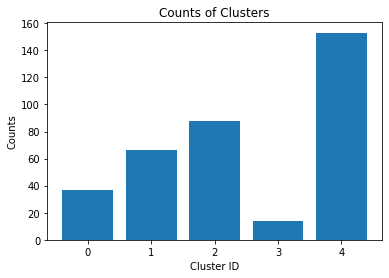

8. Plot the percentages of the clusters:

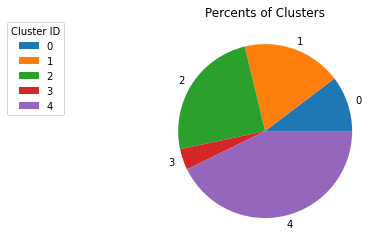


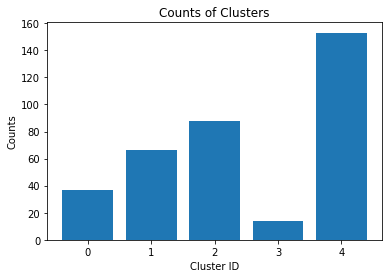

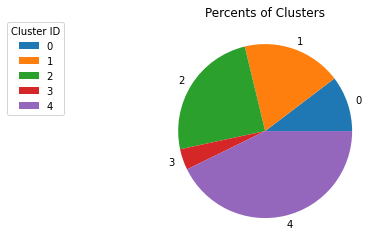

In [14]:
# COUNT RESULTS
counts = {
    0:len(cluster_0), 
    1:len(cluster_1),
    2:len(cluster_2),
    3:len(cluster_3), 
    4:len(cluster_4)
}

# PLOTS 
counts_keys = counts.keys()
counts_values = counts.values()
plt.bar(counts_keys, counts_values)
plt.title('Counts of Clusters')
plt.xlabel('Cluster ID')
plt.ylabel('Counts')
plt.show()


# PERCENTAGE RESULTS
percents = {
    0: len(cluster_0)/len(data) * 100,
    1: len(cluster_1)/len(data) * 100,
    2: len(cluster_2)/len(data) * 100,
    3: len(cluster_3)/len(data) * 100,
    4: len(cluster_4)/len(data) * 100
}

# PLOTS 
percents_keys = percents.keys()
percents_values = percents.values()
plt.pie(percents_values, labels=percents_keys)
plt.title('Percents of Clusters')
plt.legend(loc='upper right', title='Cluster ID',bbox_to_anchor=(-0.4,1.025))
plt.show()



#Classification

Read in the airport clusters and use them as labels

In [ ]:
cluster = pd.read_csv("/content/drive/Shared drives/CSCE320/Final Submission/airport_clusters.csv") 
cluster.head()

,airports,Cluster Label
0,HNL,0
1,SLC,0
2,PDX,0
3,SEA,0
4,ANC,2


In [ ]:
data['CARRIER'].unique()

array(['9E', 'AA', 'AS', 'B6', 'DL', 'EV', 'F9', 'G4', 'HA', 'MQ', 'NK',
       'OH', 'OO', 'UA', 'WN', 'YV', 'YX'], dtype=object)

Create a dictionary of airlines

In [ ]:
airline_dict = {'9E': "Pinnacle Airlines", 'AA': "American Airlines", 'AS': "Alaska Airlines", 'B6':"JetBlue Airlines", 'DL':"Delta Airlines", 'EV':"Atlantic Southeast Airlines", 
                'F9': "Frontier Airlines", 'G4':"Allegiant Air", 'HA':"Hawaiian Airlines", 'MQ':"Simmons Airlines", 'NK':"Spirit Airlines",
                'OH':"Comair", 'OO':"SkyWest  Airlines", 'UA':"United Airlines", 'WN':"Southwest Airlines", 'YV':"Mesa Airlines", 'YX':"Midwest Airlines"}
### SOURCE: https://www.census.gov/foreign-trade/reference/codes/aircarrier/ac2.txt

In [ ]:
new['CARRIER'] = new['CARRIER'].map(airline_dict)

In [ ]:
new1 = new[new['DEP_DELAY'] >= 0]
new1

Average delay by carrier

In [ ]:
test1 = new1['DEP_DELAY'].groupby(new1['CARRIER']).agg(['mean', 'count'])
test1.sort_values('count')

,mean,count
CARRIER,,
Hawaiian Airlines,15.263017,13809
Atlantic Southeast Airlines,65.860098,21901
Allegiant Air,34.209332,22610
Frontier Airlines,43.999459,27736
Spirit Airlines,39.158274,36481
Pinnacle Airlines,53.415750,37003
Mesa Airlines,49.355372,37676
Alaska Airlines,28.664239,42694
Midwest Airlines,46.584685,45055


Delay intervals used as labels in our classification

In [ ]:
delay_type = lambda x:(((0,1)[x > 0],2)[x > 5],3)[x > 45]
new['DELAY_LEVEL'] = new['DEP_DELAY'].apply(delay_type)
new['DELAY_LEVEL']

969         0
970         0
971         0
972         0
973         1
           ..
10915490    0
10915491    0
10915492    0
10915493    3
10915494    0
Name: DELAY_LEVEL, Length: 3649539, dtype: int64

In [ ]:
distance_type = lambda x:((0,1)[x > 500],2)[x > 1000]

In [ ]:
new['Distance_LEVEL'] = new['DISTANCE_y'].apply(delay_type)
new['Distance_LEVEL']

969         3
970         3
971         3
972         3
973         3
           ..
10915490    3
10915491    3
10915492    3
10915493    3
10915494    3
Name: Distance_LEVEL, Length: 3649539, dtype: int64

Plot of total delays by airlines

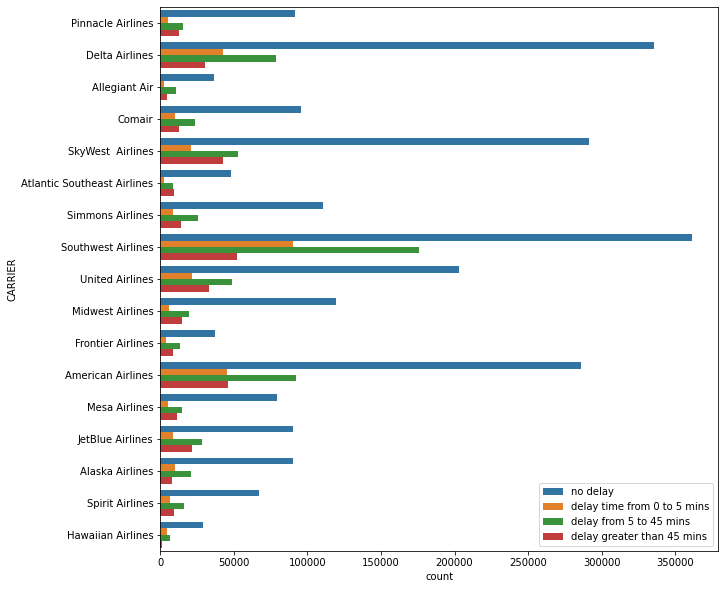

In [ ]:
fig = plt.figure(1, figsize=(10,10))
ax = sns.countplot(y="CARRIER", hue='DELAY_LEVEL', data=new)
g = plt.legend()
new_labels = ['no delay','delay time from 0 to 5 mins', 'delay from 5 to 45 mins','delay greater than 45 mins']
for t, l in zip(g.get_texts(), new_labels): t.set_text(l)

In [ ]:
s1 = new1.groupby(['ORIGIN','DEST','DISTANCE_y'])['DEP_DELAY'].size()
s1

ORIGIN  DEST  DISTANCE_y
ABE     ATL   692           157
        BNA   685             3
        CLT   481           137
        DTW   425           189
        FLL   1041           20
                           ... 
XNA     VPS   601            24
YAK     CDV   213            55
        JNU   198            28
YUM     DFW   1022           31
        PHX   160           193
Name: DEP_DELAY, Length: 6255, dtype: int64

In [ ]:
s1 = pd.DataFrame(s1)

In [ ]:
s1 = pd.DataFrame(s1)
s1 = s1.reset_index()
s1['Distance Type'] = s1['DISTANCE_y'].apply(distance_type)
s2 = s1.sort_values('DEP_DELAY', ascending=False)
s3 = s2.head(10)
s3

,ORIGIN,DEST,DISTANCE_y,DEP_DELAY,Distance Type
4325,ORD,LGA,733,3567,1
3177,LAX,SFO,337,3288,0
3295,LGA,ORD,733,3205,1
3134,LAX,JFK,2475,2917,2
5556,SFO,LAX,337,2859,0
3136,LAX,LAS,236,2637,0
225,ATL,LGA,762,2585,1
3027,LAS,LAX,236,2555,0
193,ATL,FLL,581,2343,1
229,ATL,MCO,404,2324,0


6 airports with the most delayed flights

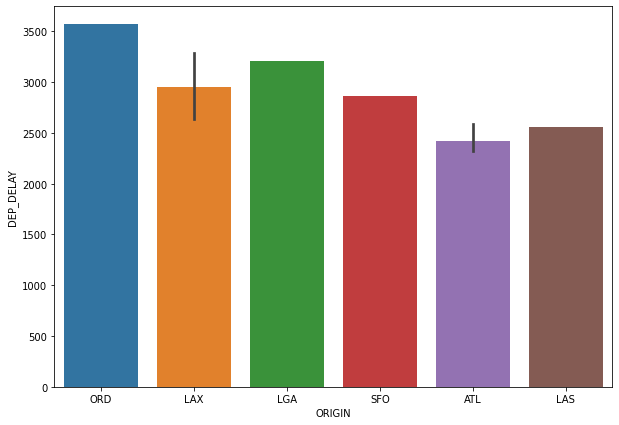

In [ ]:
fig2 = plt.figure(1, figsize=(10,7))
ax2 = sns.barplot(x = 'ORIGIN', y="DEP_DELAY", data=s3)


In [ ]:
## Now we treat cancelled flights as the most extreme delayed flights to label them
new['DEP_DELAY'] = np.where(new['CANCELED'] == 1, new['DEP_DELAY'].max(), new['DEP_DELAY'])

In [ ]:
new = new.fillna(0)

In [ ]:
new.isnull().any()

YEAR                   False
QUARTER                False
MONTH                  False
DAY_OF_MONTH           False
DAY_OF_WEEK            False
FL_DATE                False
CARRIER                False
FL_NUM                 False
Route                  False
ORIGIN                 False
DEST                   False
DEST_CITY              False
DEST_STATE             False
CRS_DEP_TIME           False
DEP_TIME               False
DEP_DELAY              False
DEP_DELAY_NEW          False
DEP_DEL15              False
DEP_DELAY_GROUP        False
DEP_TIME_BLK           False
TAXI_OUT               False
WHEELS_OFF             False
WHEELS_ON              False
TAXI_IN                False
CRS_ARR_TIME           False
ARR_TIME               False
ARR_DELAY              False
ARR_DELAY_NEW          False
ARR_DEL15              False
ARR_DELAY_GROUP        False
ARR_TIME_BLK           False
CANCELED               False
CANCELLATION_CODE      False
DIVERTED               False
CRS_ELAPSED_TI

In [ ]:
new.columns

Index(['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
       'CARRIER', 'FL_NUM', 'Route', 'ORIGIN', 'DEST', 'DEST_CITY',
       'DEST_STATE', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW',
       'DEP_DEL15', 'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'TAXI_OUT',
       'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME',
       'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP',
       'ARR_TIME_BLK', 'CANCELED', 'CANCELLATION_CODE', 'DIVERTED',
       'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
       'LATE_AIRCRAFT_DELAY', 'PASSENGERS', 'EMPFULL', 'EMPPART', 'EMPTOTAL',
       'EMPFTE', 'NET_INCOME', 'OP_REVENUES'],
      dtype='object')

In [ ]:
delay_type = lambda x:(((0,1)[x > 0],2)[x > 5],3)[x > 45]
new['DELAY_LEVEL'] = new['DEP_DELAY'].apply(delay_type)
new['DELAY_LEVEL'].nunique()

4

In [ ]:
delay_type = lambda x:(((0,1)[x > 0],2)[x > 5],3)[x > 45]
new['ARR_DELAY_LEVEL'] = new['ARR_DELAY'].apply(delay_type)
new['ARR_DELAY_LEVEL'].nunique()

4

In [ ]:
new.drop(['DEP_DELAY','DEP_DELAY_NEW', 'ARR_DELAY','DEP_DEL15','DEP_DELAY_GROUP','DEP_TIME_BLK','ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP','ARR_TIME_BLK'], axis = 1, inplace = True)

In [ ]:
new1 = new.copy()
new1 = new1.fillna(0)

In [ ]:
new1['CARRIER'].nunique()

17

In [ ]:
obj_df = new1.select_dtypes(include=['object']).copy()
obj_df.columns

Index(['FL_DATE', 'CARRIER', 'ORIGIN', 'DEST', 'DEST_CITY', 'DEST_STATE',
       'CANCELLATION_CODE'],
      dtype='object')

In [ ]:
new1.fillna(0)

In [ ]:
new1[new1['CANCELLATION_CODE'].isnull()]['CANCELLATION_CODE']

Series([], Name: CANCELLATION_CODE, dtype: object)

In [ ]:
new1['CANCELLATION_CODE'] = new1['CANCELLATION_CODE'].fillna(0)

In [ ]:
new1['CANCELLATION_CODE'].unique()

array([0, 'C', 'B', 'A', 'D'], dtype=object)

In [ ]:
new1['CANCELLATION_CODE'] = new1['CANCELLATION_CODE'].map({0: 'E', 'A': 'A', 'B':'B', 'C': 'C', 'D': 'D'})

In [ ]:
new1['CANCELLATION_CODE'].unique()

array(['E', 'C', 'B', 'A', 'D'], dtype=object)

In [ ]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
new1['Carrier_code'] = lb_make.fit_transform(new1['CARRIER'])
new1['origin_code'] = lb_make.fit_transform(new1['ORIGIN'])
new1['dest_code'] = lb_make.fit_transform(new1['DEST'])
new1['destCity_code'] = lb_make.fit_transform(new1['DEST_CITY'])
new1['destState_code'] = lb_make.fit_transform(new1['DEST_STATE'])
new1['cancellation_code'] = lb_make.fit_transform(new1['CANCELLATION_CODE'])
# new1['origin_code'] = lb_make.fit_transform(new1['ORIGIN'])

In [ ]:
new1['Carrier_code'].nunique()

17

In [ ]:
new1.drop(['CARRIER', 'ORIGIN', 'DEST', 'DEST_CITY', 'DEST_STATE', 'CANCELLATION_CODE'], axis = 1, inplace = True)

In [ ]:
new1.dtypes

YEAR                     int64
QUARTER                  int64
MONTH                    int64
DAY_OF_MONTH             int64
DAY_OF_WEEK              int64
FL_DATE                 object
FL_NUM                   int64
Route                    int64
CRS_DEP_TIME             int64
DEP_TIME               float64
TAXI_OUT               float64
WHEELS_OFF             float64
WHEELS_ON              float64
TAXI_IN                float64
CRS_ARR_TIME             int64
ARR_TIME               float64
CANCELED                 int64
DIVERTED                 int64
CRS_ELAPSED_TIME       float64
ACTUAL_ELAPSED_TIME    float64
AIR_TIME               float64
DISTANCE                 int64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
NAS_DELAY              float64
SECURITY_DELAY         float64
LATE_AIRCRAFT_DELAY    float64
PASSENGERS             float64
EMPFULL                float64
EMPPART                float64
EMPTOTAL               float64
EMPFTE                 float64
NET_INCO

In [ ]:
new1.drop(['FL_DATE'], axis = 1, inplace = True)

#### LDA (label = Departure Delay)

In [ ]:
x_features = new1.loc[:, new1.columns != 'DEP_DELAY_LEVEL']
y_target = new1['DELAY_LEVEL']

In [ ]:
import sklearn.discriminant_analysis
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
lda = LDA()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.33, random_state=42)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7313381, 41) (3602114, 41) (7313381,) (3602114,)


##### PCA (0.95) (95% variance is explained by the model)

In [ ]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# scaler.transform(X_test)
# scaler.transform(y_train)
pca = PCA(0.95)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7313381, 23) (3602114, 23) (7313381,) (3602114,)


In [ ]:
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
    #sum_training +=lda.score(X_train, y_train)
acc =  metrics.accuracy_score(y_test, y_pred)

In [ ]:
f1 =  metrics.f1_score(y_test, y_pred, average='weighted')

In [ ]:
print('Accuracy ', acc )
print('f1 ', f1 )

Accuracy  0.8929356483442779
f1  0.8719119589110301


ROC curve - The areas under the curves measure the quality of the model's prediction

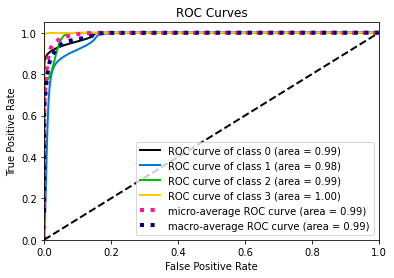

In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt 
#%matplotlib.inline
y_prob = lda.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_prob)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.3, random_state=43)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3136313, 43) (1344135, 43) (3136313,) (1344135,)


##### PCA (0.9) (90% variance is explained by the model)

In [ ]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# scaler.transform(X_test)
# scaler.transform(y_train)
pca = PCA(0.90)
#pca.fit(X_train)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
    #sum_training +=lda.score(X_train, y_train)


In [ ]:
acc2 =  metrics.accuracy_score(y_test, y_pred)

In [ ]:
f1_2 =  metrics.f1_score(y_test, y_pred, average='weighted')

In [ ]:
print('Accuracy ', acc2 )
print('f1 ', f1_2 )

Accuracy  0.8081048406596064
f1  0.8021212173073885


#### RandomForest 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.3, random_state=47)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3136313, 43) (1344135, 43) (3136313,) (1344135,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=20, random_state=0)
## start with 20 trees 

In [ ]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
pca = PCA(0.95)
#pca.fit(X_train)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

In [ ]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    X = X[:, [0,2]]
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:23: UserWarning: The following kwargs were not used by contour: 'clim'


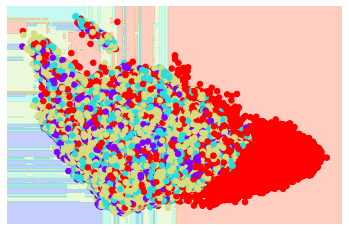

In [ ]:
visualize_classifier(model, X_train, y_train)

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
acc3 =  metrics.accuracy_score(y_test, y_pred)

In [ ]:
f1_3 =  metrics.f1_score(y_test, y_pred, average='weighted')

In [ ]:
print('Accuracy ', acc3)
print('f1 ', f1_2 )

Accuracy  0.9718064033746611
f1  0.8021212173073885


#### LDA for Arrival Delay Classification 

In [ ]:
### Classify arrival delay probability 
x_features_new = new1.loc[:, new1.columns != 'ARR_DELAY_LEVEL']
y_target_new = new1['ARR_DELAY_LEVEL']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_features_new, y_target_new, test_size=0.3, random_state=52)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3136313, 42) (1344135, 42) (3136313,) (1344135,)


In [ ]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# scaler.transform(X_test)
# scaler.transform(y_train)
pca = PCA(0.95)
# pca.fit(X_train)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
    #sum_training +=lda.score(X_train, y_train)
acc =  metrics.accuracy_score(y_test, y_pred)

In [ ]:
acc2_arr =  metrics.accuracy_score(y_test, y_pred)
f1_arr =  metrics.f1_score(y_test, y_pred, average='weighted')

In [ ]:
print("Accuracy for arrival delay classification", acc2_arr)
print("F1 for arrival delay classification", f1_arr)

Accuracy for arrival delay classification 0.7136894731555982
F1 for arrival delay classification 0.6842065046230635


### Classification with airport clusters

In [ ]:
new1['ORIGIN'] = new['ORIGIN']

In [ ]:
new1['ORIGIN'].nunique()

362

In [ ]:
cluster['airports']

0      HNL
1      SLC
2      PDX
3      SEA
4      ANC
      ... 
353    BKG
354    OTH
355    MMH
356    BFM
357    OGD
Name: airports, Length: 358, dtype: object

In [ ]:
result = pd.concat([new1, cluster], axis =1)

In [ ]:
result.drop(['ORIGIN', 'airports'], axis = 1, inplace = True)

In [ ]:
result['Cluster Label'] = result['Cluster Label'].fillna(0)

In [ ]:
result.isnull().any()

In [ ]:
x_features = result.loc[:, result.columns != 'Cluster Label']
y_target = result['Cluster Label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.3, random_state=123)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7640846, 41) (3274649, 41) (7640846,) (3274649,)


In [ ]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# scaler.transform(X_test)
# scaler.transform(y_train)
pca = PCA(0.95)
# pca.fit(X_train)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7640846, 23) (3274649, 23) (7640846,) (3274649,)


In [ ]:
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
    #sum_training +=lda.score(X_train, y_train)
acc =  metrics.accuracy_score(y_test, y_pred)

In [ ]:
f1 =  metrics.f1_score(y_test, y_pred, average='weighted')

In [ ]:
print('Accuracy ', acc)
print('f1 ', f1)

Accuracy  0.999497350708427
f1  0.9997186928259567


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

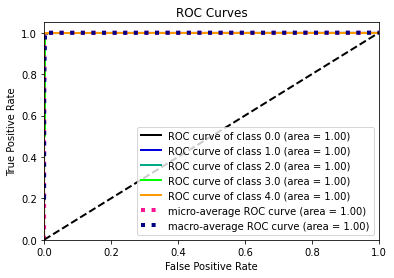

In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt 
y_prob = lda.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_prob)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=20, random_state=123456)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.3, random_state=470)

In [ ]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
pca = PCA(0.95)
#pca.fit(X_train)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
acc2 =  metrics.accuracy_score(y_test, y_pred)

In [ ]:
f1_2 =  metrics.f1_score(y_test, y_pred, average='weighted')

In [ ]:
print('Accuracy ', acc2)
print('f1 ', f1_2)

Accuracy  0.9999764860294951
f1  0.9999676615406982


In [ ]:
result.drop(['origin_code','dest_code','destCity_code','destState_code'], axis = 1, inplace = True)

In [ ]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# scaler.transform(X_test)
# scaler.transform(y_train)
pca = PCA(0.95)
# pca.fit(X_train)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7640846, 22) (3274649, 22) (7640846,) (3274649,)


In [ ]:
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
    #sum_training +=lda.score(X_train, y_train)
acc =  metrics.accuracy_score(y_test, y_pred)

In [ ]:
f1 =  metrics.f1_score(y_test, y_pred, average='weighted')

In [ ]:
print('Accuracy ', acc)
print('f1 ', f1)

Accuracy  0.9999496129203466
f1  0.9999494602360732


#Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.33, random_state=42)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(275233, 27) (135564, 27) (275233,) (135564,)


In [ ]:
lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)
rmse = metrics.mean_squared_error(y_test, y_pred, squared= False)
r2 =  metrics.r2_score(y_test, y_pred)

In [ ]:
print('rmse', rmse)
print('r2', r2)

rmse 4.245632950293868
r2 0.9999418580612714


In [ ]:
# def lasso_reg(alpha): 
kf = KFold(n_splits=5, random_state=0, shuffle=True)
# alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
# param_grid = dict(alpha=alpha)
idx_zero_coeffs = []
sum_r2 = 0
for train_index, test_index in kf.split(x_features):
    X_train, X_test = x_features.iloc[train_index], x_features.iloc[test_index]
    y_train, y_test = y_target.iloc[train_index], y_target.iloc[test_index]
#         for i in alpha: 
    ls = Lasso(alpha = 0.1)
    ls.fit(X_train, y_train)
    y_pred = ls.predict(X_test)
    i = 0
    for coeff in ls.coef_:
        if (coeff == 0):
            if not(i in idx_zero_coeffs):
                idx_zero_coeffs.append(i)
        i += 1
    sum_r2 += metrics.r2_score(y_test,y_pred)
        #print('r2', metrics.r2_score(y_test,y_pred))
print('Average r2 score', (sum_r2/5))  
print('Alpha = 0.1')
print('coefficient array', ls.coef_)
print("Indices of Zeroed Coefficients = ", idx_zero_coeffs)

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82044216.40360673, tolerance: 10239252.074087193
  positive)
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81984750.86533637, tolerance: 10089402.083773937
  positive)
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82027322.51569463, tolerance: 10155713.897849467
  positive)
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent

Average r2 score 0.9999403608716497
Alpha = 0.1
coefficient array [-0.00000000e+00 -2.80637672e-02  0.00000000e+00 -1.07314098e-03
 -3.54141678e-04  8.23927855e-01  0.00000000e+00  1.60912586e-01
 -1.24589380e-01 -6.41144312e-01  2.66665871e+03 -0.00000000e+00
 -1.36438575e-01  9.37860527e-02  5.25760340e-03  1.39792635e-01
  1.38781439e-01  1.29151315e-01  1.27364354e-01  1.40569750e-01
 -6.67789501e-06 -3.29264680e-02  5.96380545e-03  1.28255457e-03
 -1.72630737e-03  0.00000000e+00 -9.84974771e+00]
Indices of Zeroed Coefficients =  [0, 2, 3, 6, 11, 25]


c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82119831.95570208, tolerance: 10185690.568574097
  positive)


In [ ]:
kf = KFold(n_splits=5, random_state=1, shuffle=True)
# alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
# param_grid = dict(alpha=alpha)
idx_zero_coeffs = []
sum_r2 = 0
for train_index, test_index in kf.split(x_features):
    X_train, X_test = x_features.iloc[train_index], x_features.iloc[test_index]
    y_train, y_test = y_target.iloc[train_index], y_target.iloc[test_index]
#         for i in alpha: 
    ls = Lasso(alpha = 1)
    ls.fit(X_train, y_train)
    y_pred = ls.predict(X_test)
    i = 0
    for coeff in ls.coef_:
        if (coeff == 0):
            if not(i in idx_zero_coeffs):
                idx_zero_coeffs.append(i)
        i += 1
    sum_r2 += metrics.r2_score(y_test,y_pred)
        #print('r2', metrics.r2_score(y_test,y_pred))
print('Average r2 score', (sum_r2/5))  
print('Alpha = 1')
print('coefficient array', ls.coef_)
print("Indices of Zeroed Coefficients = ", idx_zero_coeffs)

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82243875.71851197, tolerance: 10139578.41305908
  positive)
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92196543.66138932, tolerance: 10224848.988322265
  positive)
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10173735.251013905, tolerance: 10173316.006714312
  positive)
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent

Average r2 score 0.9990885240891485
Alpha = 1
coefficient array [-0.00000000e+00 -4.39350138e-02 -0.00000000e+00 -0.00000000e+00
 -5.25238666e-04  6.19097167e-01 -0.00000000e+00  2.92041944e-01
  8.36342932e-02 -0.00000000e+00  2.33694514e+03 -0.00000000e+00
 -3.91547637e-01  1.37747570e-01  2.90358007e-02  1.46410930e-03
  2.03797332e-03  2.71123665e-03 -0.00000000e+00  0.00000000e+00
 -5.94071072e-05 -8.87209012e-02  5.35886237e-03  6.53199188e-03
 -6.34780842e-03  3.02088085e-03 -1.01116161e+02]
Indices of Zeroed Coefficients =  [0, 2, 3, 6, 9, 11, 18, 19, 22]


c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89866711.52918783, tolerance: 10206935.43718301
  positive)


In [ ]:
kf = KFold(n_splits=5, random_state=2, shuffle=True)
# alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
# param_grid = dict(alpha=alpha)
idx_zero_coeffs = []
sum_r2 = 0
for train_index, test_index in kf.split(x_features):
    X_train, X_test = x_features.iloc[train_index], x_features.iloc[test_index]
    y_train, y_test = y_target.iloc[train_index], y_target.iloc[test_index]
#         for i in alpha: 
    ls = Lasso(alpha = 5)
    ls.fit(X_train, y_train)
    y_pred = ls.predict(X_test)
    i = 0
    for coeff in ls.coef_:
        if (coeff == 0):
            if not(i in idx_zero_coeffs):
                idx_zero_coeffs.append(i)
        i += 1
    sum_r2 += metrics.r2_score(y_test,y_pred)
        #print('r2', metrics.r2_score(y_test,y_pred))
print('Average r2 score', (sum_r2/5))  
print('Alpha = 5')
print('coefficient array', ls.coef_)
print("Indices of Zeroed Coefficients = ", idx_zero_coeffs)

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107535312.68719006, tolerance: 10108344.286111465
  positive)
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44304301.2123456, tolerance: 10193573.943420539
  positive)


Average r2 score 0.9784934088091856
Alpha = 5
coefficient array [-0.00000000e+00 -1.21217924e-01 -0.00000000e+00 -0.00000000e+00
 -1.16806173e-03 -1.95492438e-01 -0.00000000e+00  1.16102024e+00
  0.00000000e+00 -0.00000000e+00  8.66527206e+02 -0.00000000e+00
 -1.45744890e+00  2.73198989e-01  1.33953725e-01  1.21428624e-02
  2.00978230e-02  7.12310680e-02 -0.00000000e+00 -0.00000000e+00
 -2.93448658e-04 -3.17919176e-01  0.00000000e+00  2.87865712e-02
 -2.55937251e-02  1.39241964e-02 -5.08253861e+02]
Indices of Zeroed Coefficients =  [0, 2, 3, 6, 8, 9, 11, 18, 19, 22]


In [ ]:
kf = KFold(n_splits=5, random_state=3, shuffle=True)
# alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
# param_grid = dict(alpha=alpha)
idx_zero_coeffs = []
sum_r2 = 0
for train_index, test_index in kf.split(x_features):
    X_train, X_test = x_features.iloc[train_index], x_features.iloc[test_index]
    y_train, y_test = y_target.iloc[train_index], y_target.iloc[test_index]
#         for i in alpha: 
    ls = Lasso(alpha = 10)
    ls.fit(X_train, y_train)
    y_pred = ls.predict(X_test)
    i = 0
    for coeff in ls.coef_:
        if (coeff == 0):
            if not(i in idx_zero_coeffs):
                idx_zero_coeffs.append(i)
        i += 1
    sum_r2 += metrics.r2_score(y_test,y_pred)
        #print('r2', metrics.r2_score(y_test,y_pred))
print('Average r2 score', (sum_r2/5))  
print('Alpha = 10')
print('coefficient array', ls.coef_)
print("Indices of Zeroed Coefficients = ", idx_zero_coeffs)

Average r2 score 0.9529449424672343
Alpha = 10
coefficient array [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -1.87639149e-03 -7.97903269e-01 -0.00000000e+00  1.75142402e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -2.23027639e+00  3.09838017e-01  2.16876902e-01  9.95786148e-03
  2.05613403e-02  1.11243398e-01 -0.00000000e+00 -4.61344812e-03
 -4.29277103e-04 -4.26343624e-01  0.00000000e+00  4.57433696e-02
 -4.00913060e-02  1.93699434e-02 -7.34193719e+02]
Indices of Zeroed Coefficients =  [0, 2, 3, 6, 8, 9, 10, 11, 18, 19, 22, 25, 1]


###Classification and Regression results summary

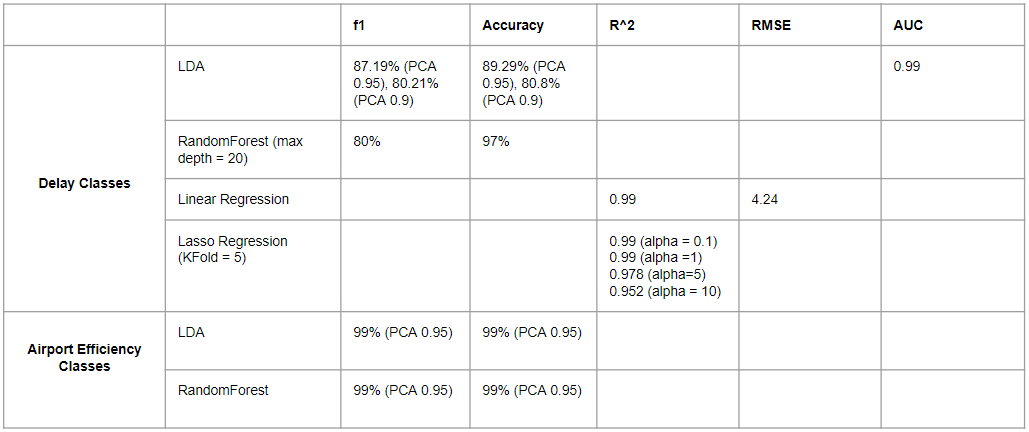

We achieved nearly perfect scores for classification with airports efficiency clusters used as the labels. This is predictable since we ran the model twice. The reason we added this step is to validate our clustering results

# Visualization of Final Data

* Plotly is using Mapbox API in the backend to plot this beautiful map.
* We chose the Open street map as it is open source map, which is being updated on regualar basis and also it was the perfect combination with the color scheme we chose.

In [ ]:
airport_df = pd.read_csv("/content/drive/Shared drives/CSCE320/Final Submission/airport_loc_stats_comb.csv",low_memory=False)
fig = px.scatter_mapbox(airport_df, 
                        lat="LATITUDE", 
                        lon="LONGITUDE",     
                        color="efficiency_score", 
                        size="efficiency_score",
                        hover_name="airports",
                        hover_data=['DISPLAY_AIRPORT_NAME', 'DISPLAY_AIRPORT_CITY_NAME_FULL', 'average_dep_delay', 'average_arr_delay', 'cancel_rate', 'weather_delay_rate', 'carrier_delay_rate', 'avg_passengers_per_day', 'total_flights', 'total_departures'],
                        color_continuous_scale=px.colors.sequential.Jet, 
                        size_max=8,
                        mapbox_style="open-street-map",
                        title="US Airports Efficiency Map",
                        zoom=2)
fig.show()

In [ ]:
#Saving the visualization into HTML File
pio.write_html(fig, file='index.html', auto_open=True)
!cp index.html "/content/drive/Shared drives/CSCE320/Final Submission/"

We are uploading and making HTML File manually on github, This process can be automated, but was not achieved because of time. \\
Link to visualization: [Click Here](https://ukantesaria.github.io/aerometrics/ "Title")